# Import Libraries

In [160]:
import datetime
import logging
import time
import azure.functions as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from datetime import date, timedelta
from shared_code import utils

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Initialize Storage Account

In [2]:
azure_utils = utils.AzureUtils()
secret_client = azure_utils.initialize_key_vault()

sa_secret = azure_utils.get_key_vault_secret(secret_client, 'sa-booli')
sa_name = azure_utils.get_key_vault_secret(secret_client, 'sa-name')
storage_account = azure_utils.initialize_storage_account_ad(sa_secret.value, sa_name.value)

# Scraping & Storing Data

In [13]:
object_type = "Lägenhet"
minSoldDate = "2022-01-01"
maxSoldDate = "2022-12-31"
rooms = ""
area_id = 143

booli_utils = utils.Booli()

data = booli_utils.run_query_sold(object_type, minSoldDate, maxSoldDate, rooms, area_id, 1)
total_number_of_pages = data["data"]["search"]["pages"]
total_number_of_objects = data["data"]["search"]["totalCount"]
total_number_of_pages

res = []
for page in range(1, total_number_of_pages + 1):
    print(f'Scraping page: {page} / {total_number_of_pages}')
    data = booli_utils.run_query_sold(object_type, minSoldDate, maxSoldDate, rooms, area_id, page)
    
    for object in data["data"]["search"]["result"]:
        res.append(object)
    
    print(f"Total number of objects stored {len(res)} / {total_number_of_objects}")
    print("")
    print("--------------------------------------------")
    print("")
    
df = pd.json_normalize(res)

azure_utils.upload_csv_to_datalake(df, "raw/sold", f"Sold_{object_type}_{rooms}_{area_id}_{minSoldDate}_{maxSoldDate}.csv")

Scraping page: 1 / 279
Total number of objects stored 35 / 9739

--------------------------------------------

Scraping page: 2 / 279
Total number of objects stored 70 / 9739

--------------------------------------------

Scraping page: 3 / 279
Total number of objects stored 105 / 9739

--------------------------------------------

Scraping page: 4 / 279
Total number of objects stored 140 / 9739

--------------------------------------------

Scraping page: 5 / 279
Total number of objects stored 175 / 9739

--------------------------------------------

Scraping page: 6 / 279
Total number of objects stored 210 / 9739

--------------------------------------------

Scraping page: 7 / 279
Total number of objects stored 245 / 9739

--------------------------------------------

Scraping page: 8 / 279
Total number of objects stored 280 / 9739

--------------------------------------------

Scraping page: 9 / 279
Total number of objects stored 315 / 9739

----------------------------------------

# Data Cleaning

In [16]:
utils_DataFactory = utils.DataFactory()
data_cleaning = utils_DataFactory.get_formatter("Cleaning")

columns_to_drop = ["floor", "soldPriceAbsoluteDiff", "soldPricePercentageDiff", "__typename", "listPrice", "rooms", "soldSqmPrice", "livingArea", "rent"]
non_numeric_columns = ["streetAddress", "objectType", "descriptiveAreaName", "soldPriceType", "soldDate", "url", "__typename"]
columns_to_rename = {
    "soldPrice.raw": "soldPriceInSek",
    "floor.raw": "floorNumber",
    "rent.raw": "rentInSek",
    "soldSqmPrice.raw": "soldSqmPriceInSek",
    "soldPriceAbsoluteDiff.raw": "soldPriceVsListPriceDiffInSek",
    "soldPricePercentageDiff.raw": "soldPriceVsListPriceDiffInPercentage",
    "listPrice.raw": "listPriceInSek",
    "livingArea.raw": "livingAreaInSqm",
    "rooms.raw": "numberOfRooms"
}

df_clean = (
    azure_utils.ingest_raw_data("sold/Sold_Lägenhet")
    .pipe(data_cleaning.drop_dataframe_columns, columns_to_drop)
    .pipe(data_cleaning.set_dtype_to_numeric, non_numeric_columns)
    .pipe(data_cleaning.change_timestamp_format, "soldDate")
    .pipe(data_cleaning.rename_df_columns, columns_to_rename)
)
df_clean.head()

,booliId,streetAddress,constructionYear,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber
0,1297209,Drottningholmsvägen 48,2011.0,Lägenhet,St Göran,Slutpris,18.0,2012-11-06,59.332038,18.022488,/bostad/342585,2650000,2193.0,63095.0,0.0,0.0,2650000.0,42.0,2.0,NaN
1,1309519,Lilla Västerbron 6,2009.0,Lägenhet,Fredhäll,Slutpris,13.0,2012-11-21,59.331375,18.023321,/annons/1309519,2650000,2989.0,63095.0,150000.0,6.0,2500000.0,42.0,2.0,NaN
2,1313807,Igeldammsgatan 20,1932.0,Lägenhet,St Göran,Slutpris,13.0,2012-11-28,59.336983,18.024736,/annons/1313807,2110000,1708.0,57027.0,110000.0,5.5,2000000.0,37.0,1.5,2.0
3,1284962,Hjärnegatan 4,NaN,Lägenhet,Kungsholmen,Slutpris,13.0,2012-10-17,59.332541,18.042303,/annons/1284962,2970000,2809.0,54000.0,-30000.0,-1.0,3000000.0,55.0,2.0,4.0
4,1282231,Vänskapsvägen 55,NaN,Lägenhet,Stora Essingen,Slutpris,25.0,2012-10-24,59.321561,17.988416,/bostad/792125,2000000,3698.0,41667.0,-200000.0,-9.1,2200000.0,48.0,2.5,3.0


# Get Location Data Using GeoPy

In [ ]:
geolocator = Nominatim(user_agent = "booli_feature_engineering")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds = 0.1)

df_clean["Location"] = df_clean.apply(lambda row: reverse(f"{row.latitude}, {row.longitude}"), axis = 1)
df_clean.head()

In [ ]:
geolocator = Nominatim(user_agent = "booli_feature_engineering")

df_clean["Location"] = df_clean.streetAddress.apply(geolocator.geocode)
df_clean.head()

## Uploading Cleaned Data to Data Lake

In [19]:
parquet_file = df_clean.to_parquet(index = False)

azure_utils.upload_csv_to_datalake(df_clean, f"silver/sold_clean", f"Sold_{date.today()}.csv")   

# General Statistics of the Dataframe

## Data Types

In [20]:
data_cleaning.get_data_types(df_clean)

,Data Type
booliId,int64
streetAddress,object
constructionYear,float64
objectType,object
descriptiveAreaName,object
soldPriceType,object
daysActive,float64
soldDate,datetime64[ns]
latitude,float64
longitude,float64


## Statistical Overview

In [21]:
df_clean.describe()

,booliId,constructionYear,daysActive,latitude,longitude,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber
count,9.190500e+04,83806.000000,91358.000000,91905.000000,91905.000000,9.190500e+04,90883.000000,91763.000000,8.854900e+04,8.854900e+04,8.856200e+04,91763.000000,91658.000000,82762.000000
mean,3.067105e+06,1934.219340,20.939228,59.331941,18.052912,5.434346e+06,2737.223463,92356.271842,4.400836e+05,1.535117e+03,4.920888e+06,59.258453,2.271220,2.993068
std,1.120357e+06,37.016594,39.548668,0.013083,0.028040,3.425237e+06,1272.096168,21619.070462,5.258529e+05,4.536716e+05,3.137662e+06,30.235069,1.022155,2.156795
min,-1.015519e+07,1300.000000,0.000000,59.279156,17.873617,4.000000e+04,1.000000,10000.000000,-6.029043e+06,-7.430000e+01,0.000000e+00,9.400000,1.000000,-3.000000
25%,2.033118e+06,1912.000000,11.000000,59.318601,18.033127,3.325000e+06,1861.000000,77778.000000,1.050000e+05,2.700000e+00,2.975000e+06,38.000000,2.000000,1.500000
50%,3.253954e+06,1930.000000,13.000000,59.334938,18.051444,4.495000e+06,2487.000000,90794.000000,3.800000e+05,9.700000e+00,3.995000e+06,52.500000,2.000000,3.000000
75%,4.028998e+06,1941.000000,19.000000,59.342255,18.077724,6.500000e+06,3389.000000,104936.000000,6.500000e+05,1.670000e+01,5.950000e+06,74.000000,3.000000,4.000000
max,4.848694e+06,2023.000000,2832.000000,59.373271,18.142138,1.350000e+08,35803.000000,755556.000000,1.500000e+07,1.349999e+08,7.500000e+07,970.000000,19.000000,99.900000


## Missing Values

In [22]:
data_cleaning.get_missing_values_percent(df_clean)

,Missing Values [%]
booliId,0.000000
streetAddress,0.000000
constructionYear,8.812361
objectType,0.000000
descriptiveAreaName,0.000000
soldPriceType,0.000000
daysActive,0.595180
soldDate,0.000000
latitude,0.000000
longitude,0.000000


In [81]:
def plot_distribution(dataframe, column, ax, bins_ = 100):
    dataframe[column].plot(kind = "hist", bins = bins_, ax = ax, color = "lightblue", ec = "black", linewidth = 1)
    
    min_ylim, max_ylim = ax.get_ylim()
    mean = dataframe[column].mean()
    std = dataframe[column].std()
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.set_xlabel(column)
    ax.ticklabel_format(style = "plain", axis = "x")
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    ax.axvline(mean, color = "k", linestyle = "--", linewidth = 1)
    ax.set_title("Histogram of {}: $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(column, mean, std))

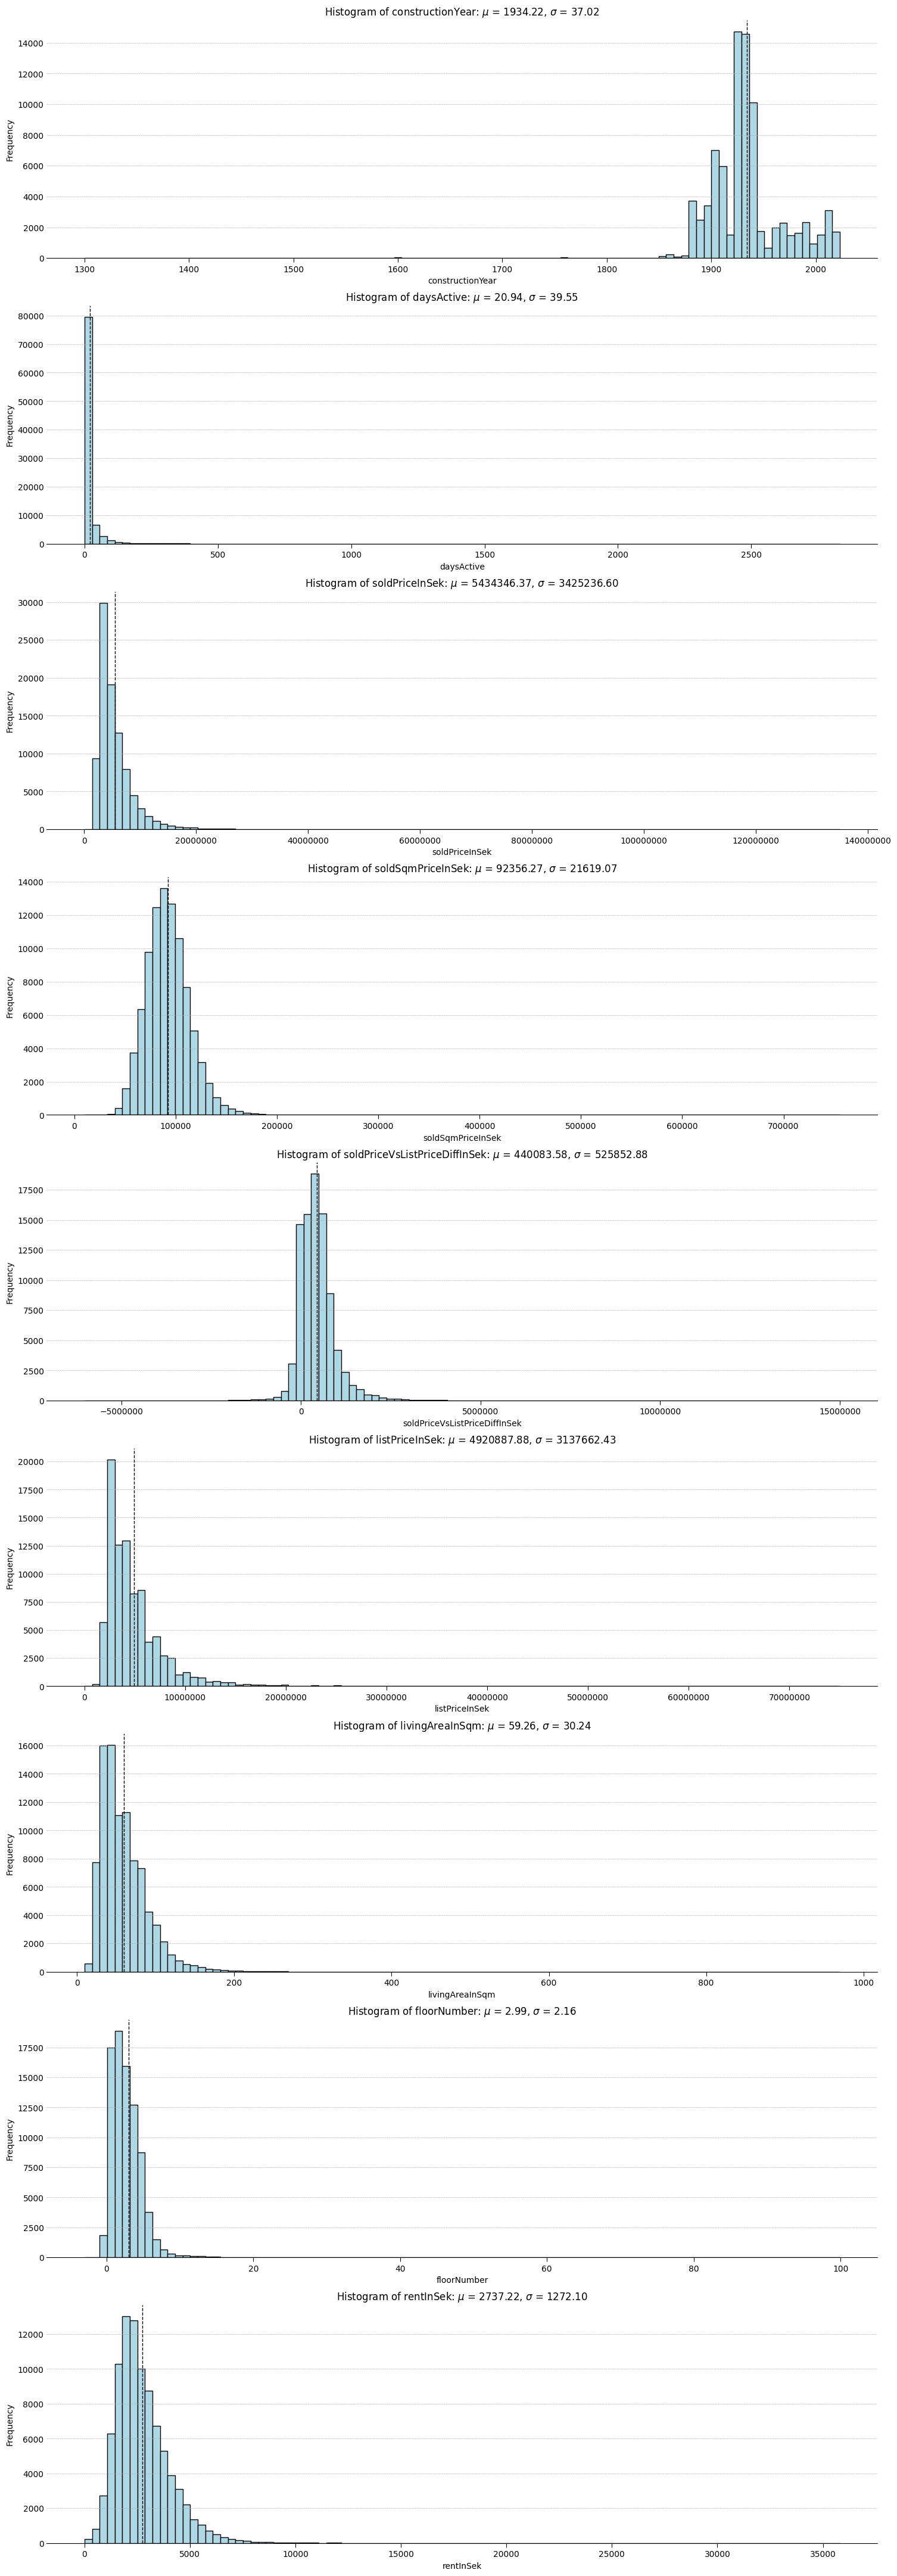

In [84]:
fig, axs = plt.subplots(nrows = 9, figsize = (18,55))

plot_distribution(df_clean, "constructionYear", axs[0])
plot_distribution(df_clean, "daysActive", axs[1])
plot_distribution(df_clean, "soldPriceInSek", axs[2])
plot_distribution(df_clean, "soldSqmPriceInSek", axs[3])
plot_distribution(df_clean, "soldPriceVsListPriceDiffInSek", axs[4])
plot_distribution(df_clean, "listPriceInSek", axs[5])
plot_distribution(df_clean, "livingAreaInSqm", axs[6])
plot_distribution(df_clean, "floorNumber", axs[7])
plot_distribution(df_clean, "rentInSek", axs[8])

In [170]:
def plot_dates(dataframe, date_col, measure_col, agg_func = "count"):
    if agg_func == "count":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).count()
    elif agg_func == "sum":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).sum()
    elif agg_func == "mean":
        temp = dataframe[[date_col, measure_col]].set_index(date_col).groupby([pd.Grouper(freq = "M")]).mean()
    else:
        return print("Choose a correct aggregation function")
        
    ax = temp.plot(kind = "line", figsize = (25, 10))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    plt.show()

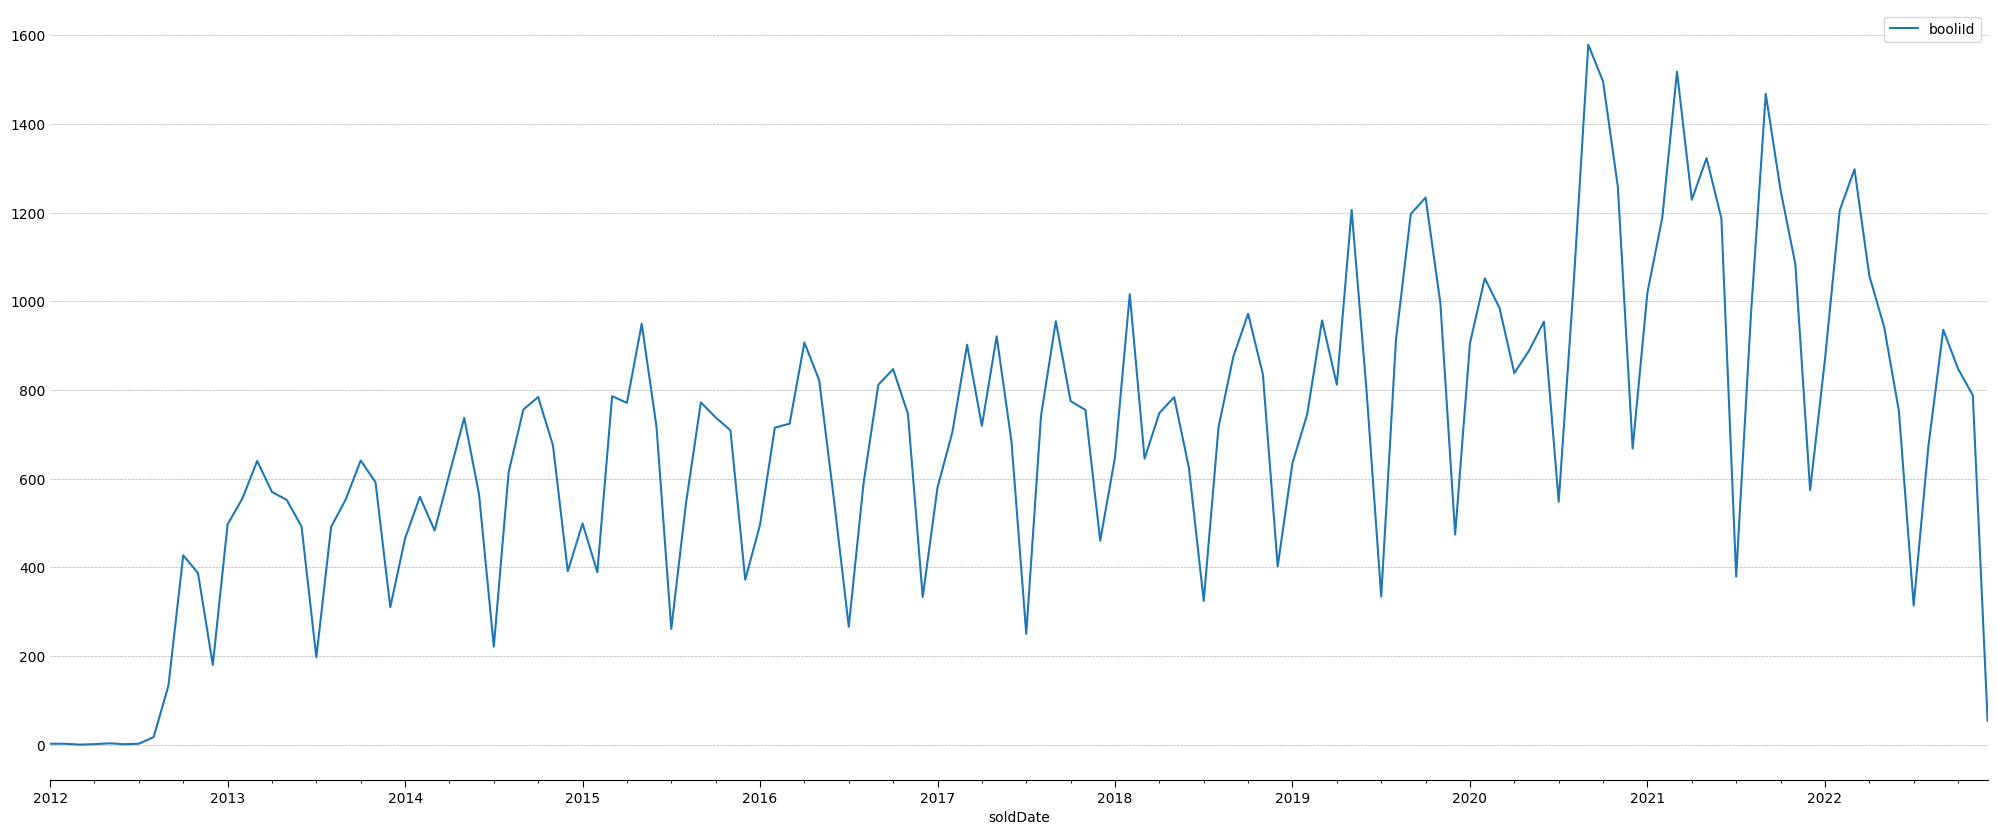

In [171]:
df_clean["soldDate"] = pd.to_datetime(df_clean["soldDate"], format = "%Y-%m-%d")
plot_dates(df_clean, "soldDate", "booliId", "count")
# df_clean[["soldDate", "booliId"]].set_index("soldDate").groupby([pd.Grouper(freq = "M")]).count()

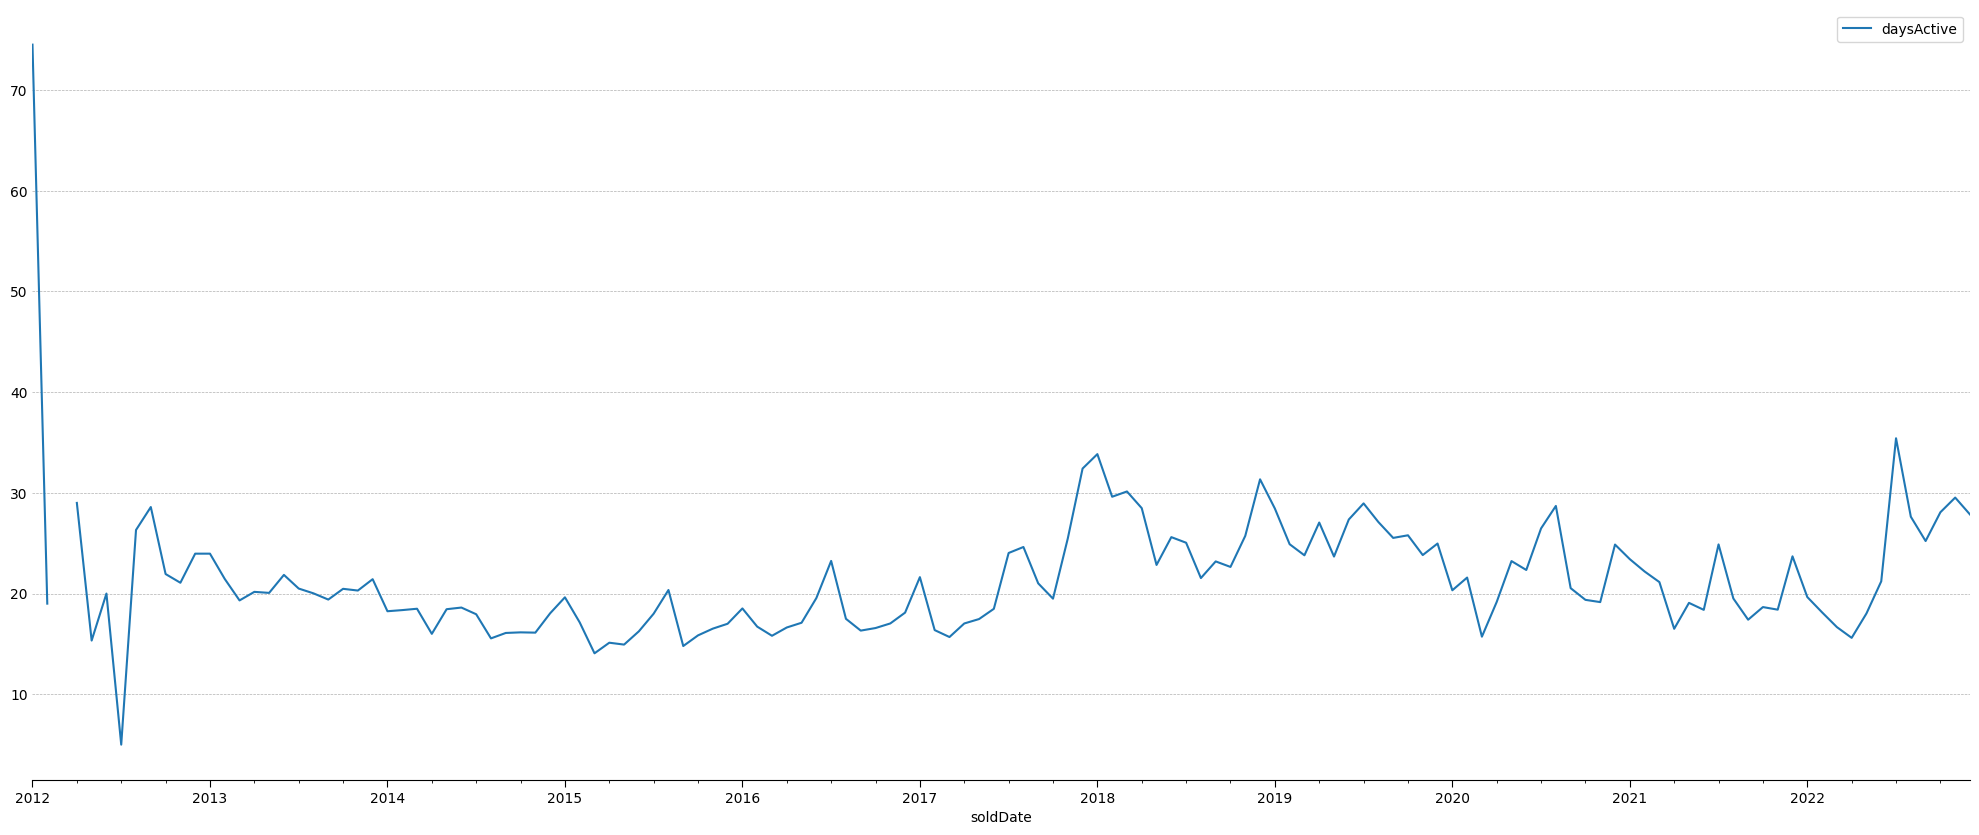

In [172]:
plot_dates(df_clean, "soldDate", "daysActive", "mean")

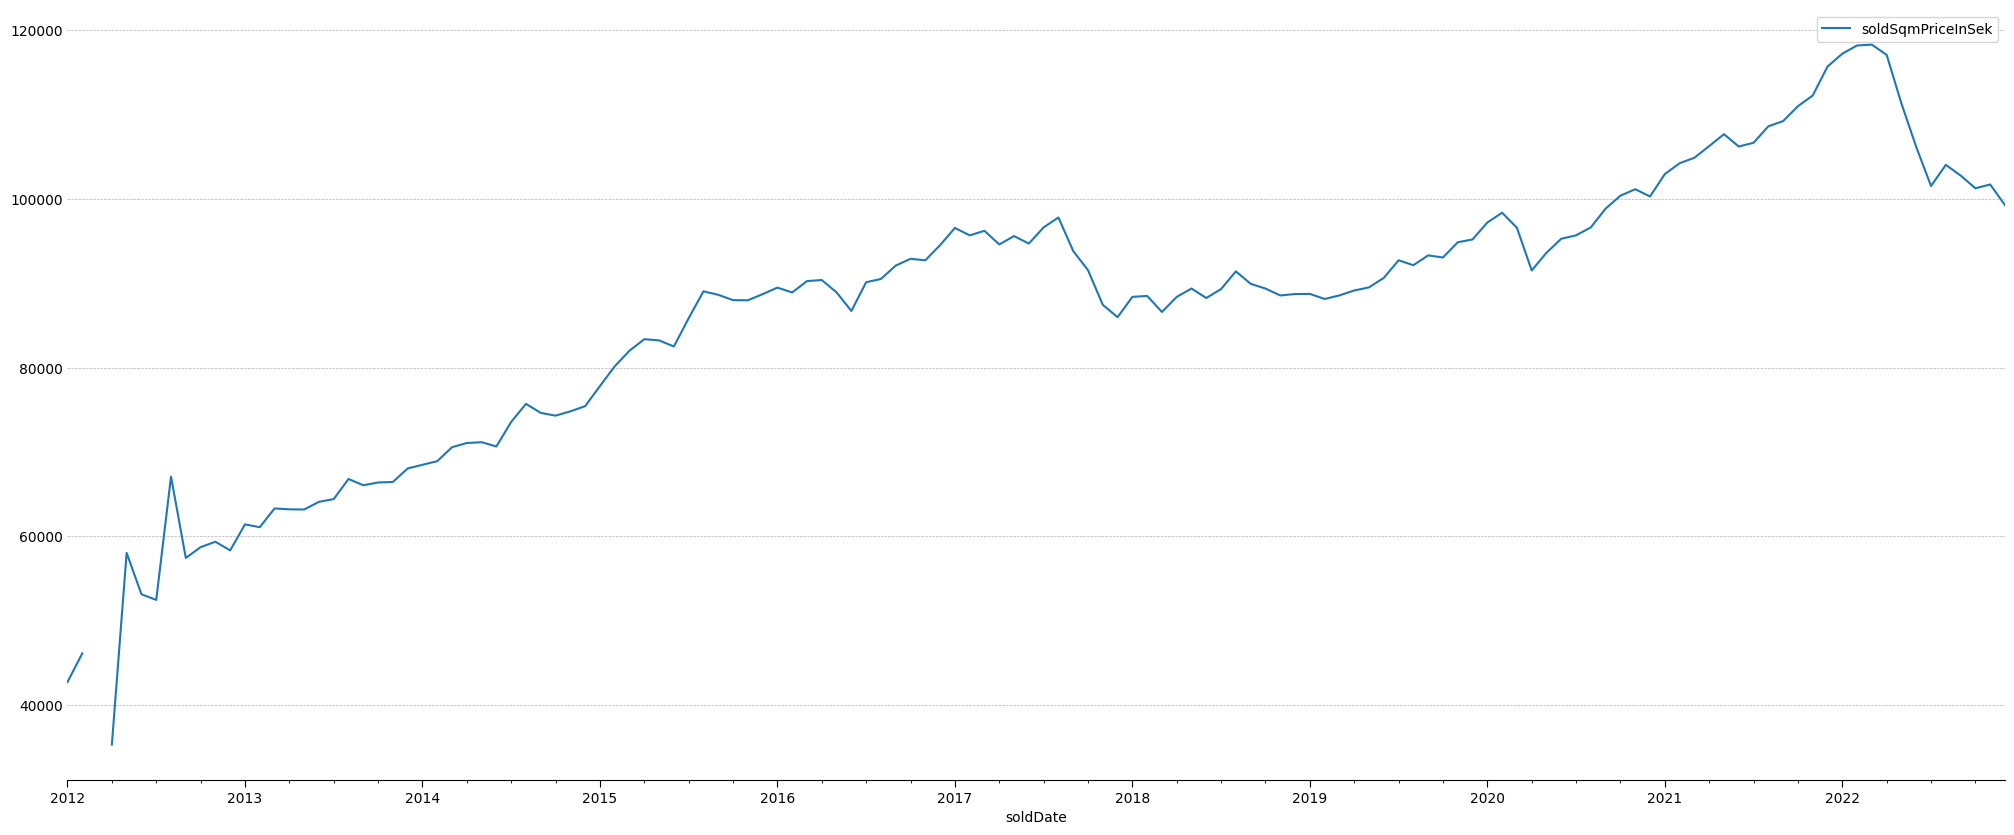

In [173]:
plot_dates(df_clean, "soldDate", "soldSqmPriceInSek", "mean")

<AxesSubplot: xlabel='soldDate'>

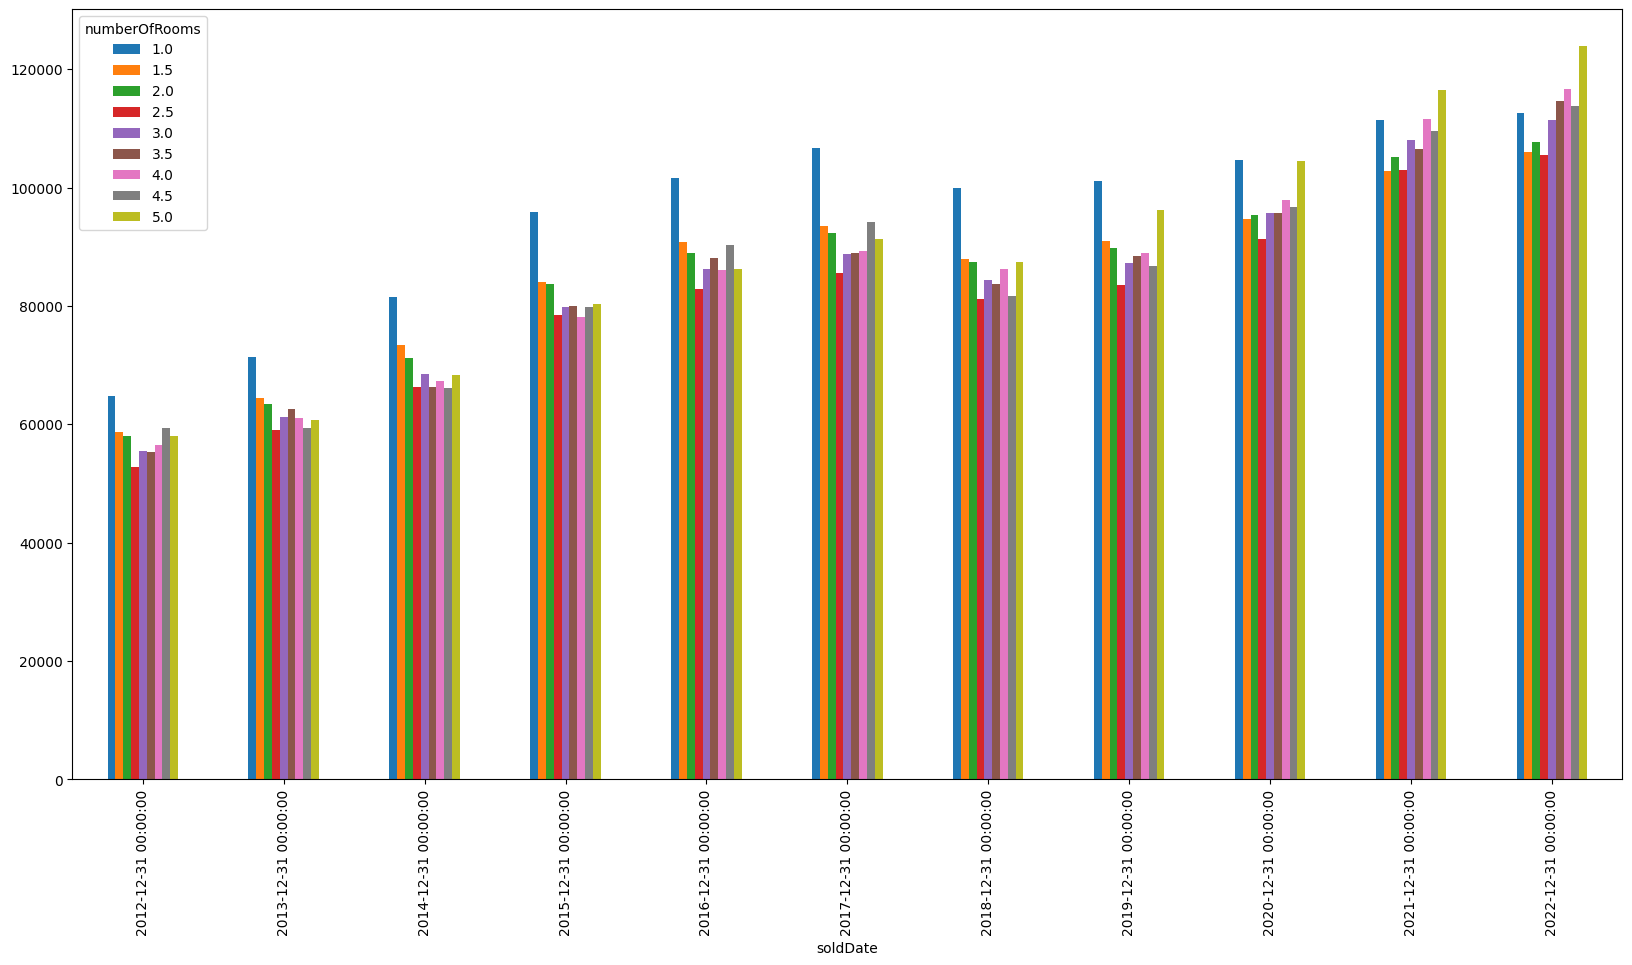

In [191]:
test = df_clean[["soldDate", "soldSqmPriceInSek", "numberOfRooms"]].set_index("soldDate").groupby([pd.Grouper(freq = "Y"), "numberOfRooms"])["soldSqmPriceInSek"].mean().reset_index()
test = test[test.numberOfRooms <= 5]
test.pivot(index = "soldDate", columns = "numberOfRooms", values = "soldSqmPriceInSek").plot(kind = "bar", figsize = (20, 10))

In [202]:
df_clean[["descriptiveAreaName", "booliId"]].groupby(["descriptiveAreaName"]).count().sort_values(by = "booliId", ascending = False).head(30)

# pd.DataFrame(df_clean.descriptiveAreaName.unique(), columns = ["Area Name"])

,booliId
descriptiveAreaName,
Vasastan,17902
Kungsholmen,17129
Södermalm,15244
Östermalm,10032
Gärdet,3874
Katarina,1429
Södermalm Katarina,1060
Essingeöarna,1006
Norrmalm,942


In [270]:
df_area_price = df_clean[["soldDate", "descriptiveAreaName", "soldSqmPriceInSek"]].set_index("soldDate")
df_area_price = df_area_price[df_area_price.descriptiveAreaName.isin(["Vasastan", "Kungsholmen", "Södermalm", "Östermalm"])]
df_area_price = df_area_price[df_area_price.index >= "2012-12-31"]
df_area_price = df_area_price.groupby([pd.Grouper(freq = "M"), "descriptiveAreaName"]).mean().reset_index()
df_area_price = df_area_price.pivot(index = "soldDate", columns = "descriptiveAreaName", values = "soldSqmPriceInSek")
df_area_price["Mean"] = df_area_price.mean(axis = 1)

In [271]:
df_area_price.reset_index().head()

descriptiveAreaName,soldDate,Kungsholmen,Södermalm,Vasastan,Östermalm,Mean
0,2013-01-31,59320.109756,60340.608108,66087.478261,66009.318182,62939.378577
1,2013-02-28,56972.075269,59304.747253,65676.434783,67216.384615,62292.410480
2,2013-03-31,61103.741071,61005.252874,66525.214953,70012.962963,64661.792965
3,2013-04-30,61214.252525,62196.533333,67286.456311,69905.116279,65150.589612
4,2013-05-31,62088.827957,61526.765432,65177.415584,72397.000000,65297.502243


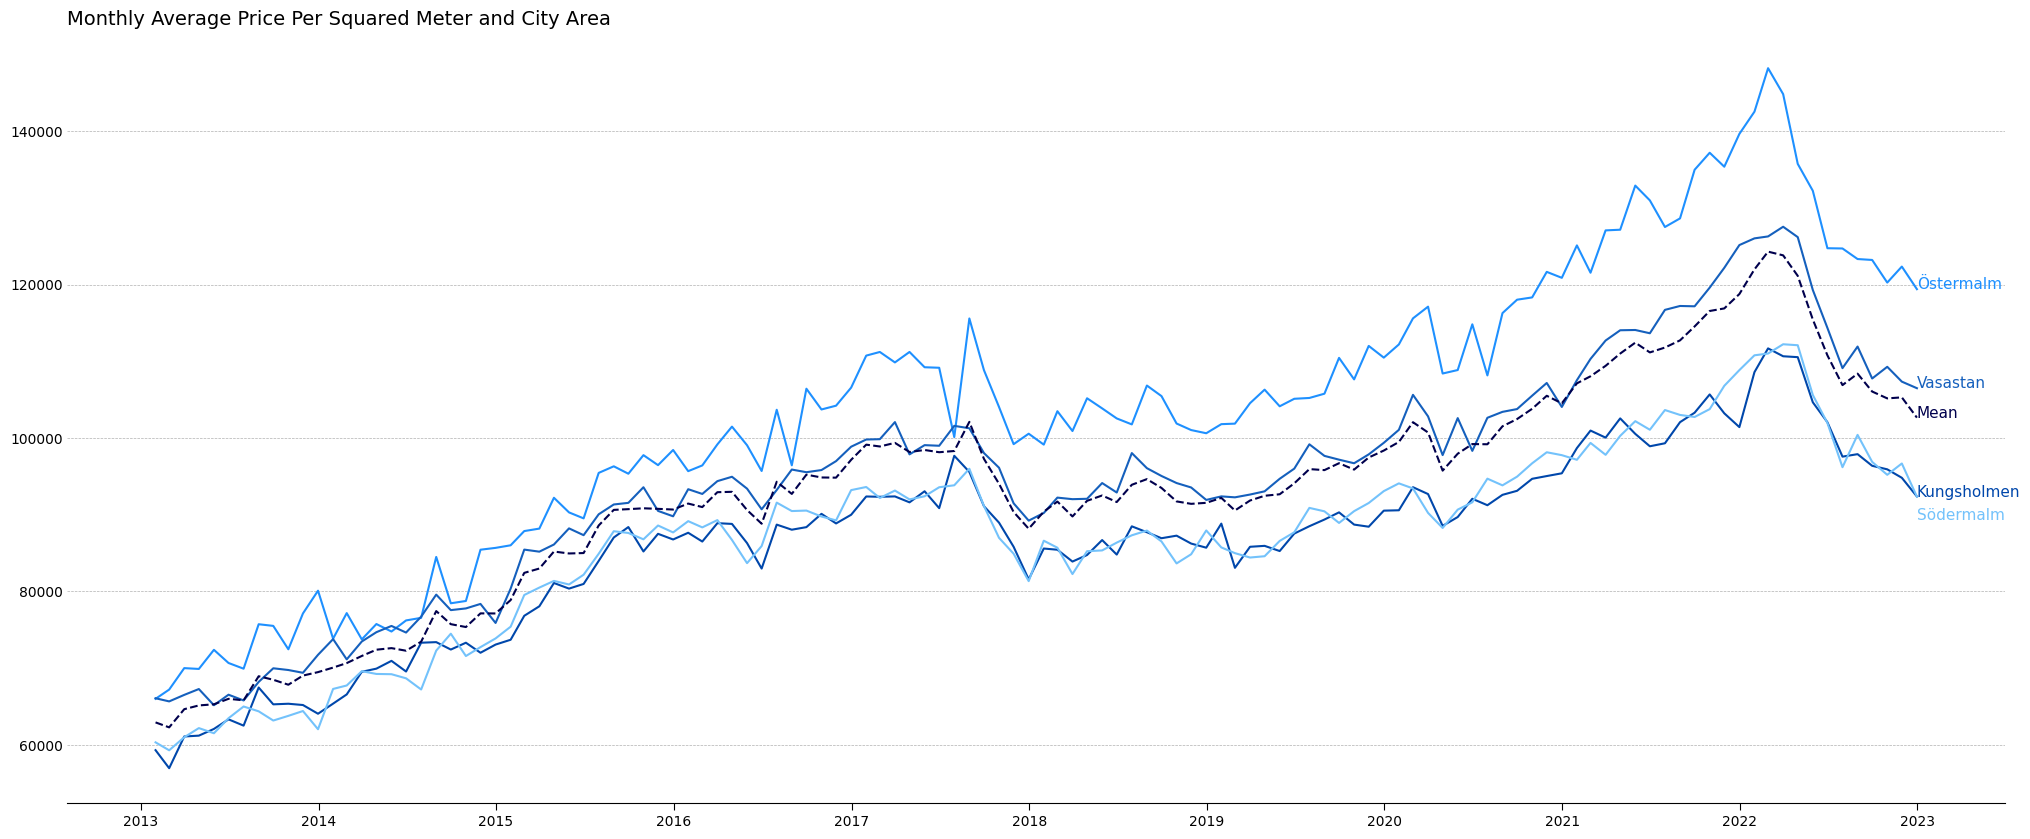

In [282]:
def plot_shit(dataframe, ax):
    
    color_tableau = {
        "Kungsholmen": "#0047ab",
        "Östermalm": "#1E90FF",
        "Södermalm": "#73c2fb",
        "Vasastan": "#1560BD",
        "Mean": "#00004d"
    }
    
    temp = dataframe

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)
    
    ax.tick_params(
        axis="y",  
        length = 0
    ) 
    ax.tick_params(
        axis="x",  
        length = 5
    ) 
    
    for area, color in color_tableau.items():
        if area == "Mean":
            plt.plot(temp["soldDate"].values, 
                    temp[area].values, 
                    lw = 1.5,
                    linestyle = "--",
                    color = color)
        else:
            plt.plot(temp["soldDate"].values, 
                    temp[area].values, 
                    lw = 1.5, 
                    color = color)
            
        y_pos = temp[area].values[-1] - 0.5
        if area == "Södermalm":    
            y_pos += -3000
            
        plt.text(temp.soldDate.max(), y_pos, area, fontsize = 11, color = color) 
            
    ax.set_title("Monthly Average Price Per Squared Meter and City Area", loc = "left", fontsize = 14)



plt.figure(figsize = (25, 10))
ax = plt.subplot(111)
plot_shit(df_area_price.reset_index(), ax)




In [283]:
df_clean.head()

,booliId,streetAddress,constructionYear,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,soldPriceInSek,rentInSek,soldSqmPriceInSek,soldPriceVsListPriceDiffInSek,soldPriceVsListPriceDiffInPercentage,listPriceInSek,livingAreaInSqm,numberOfRooms,floorNumber
0,1297209,Drottningholmsvägen 48,2011.0,Lägenhet,St Göran,Slutpris,18.0,2012-11-06,59.332038,18.022488,/bostad/342585,2650000,2193.0,63095.0,0.0,0.0,2650000.0,42.0,2.0,NaN
1,1309519,Lilla Västerbron 6,2009.0,Lägenhet,Fredhäll,Slutpris,13.0,2012-11-21,59.331375,18.023321,/annons/1309519,2650000,2989.0,63095.0,150000.0,6.0,2500000.0,42.0,2.0,NaN
2,1313807,Igeldammsgatan 20,1932.0,Lägenhet,St Göran,Slutpris,13.0,2012-11-28,59.336983,18.024736,/annons/1313807,2110000,1708.0,57027.0,110000.0,5.5,2000000.0,37.0,1.5,2.0
3,1284962,Hjärnegatan 4,NaN,Lägenhet,Kungsholmen,Slutpris,13.0,2012-10-17,59.332541,18.042303,/annons/1284962,2970000,2809.0,54000.0,-30000.0,-1.0,3000000.0,55.0,2.0,4.0
4,1282231,Vänskapsvägen 55,NaN,Lägenhet,Stora Essingen,Slutpris,25.0,2012-10-24,59.321561,17.988416,/bostad/792125,2000000,3698.0,41667.0,-200000.0,-9.1,2200000.0,48.0,2.5,3.0


# Drop nan Columns

In [293]:
def get_nan_per_column(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(len(df))
    print('\n')
    print(missing_data)


get_nan_per_column(df_clean)

91905


                                      Total   Percent
floorNumber                            9143  0.099483
constructionYear                       8099  0.088124
soldPriceVsListPriceDiffInPercentage   3356  0.036516
soldPriceVsListPriceDiffInSek          3356  0.036516
listPriceInSek                         3343  0.036375
rentInSek                              1022  0.011120
daysActive                              547  0.005952
numberOfRooms                           247  0.002688
livingAreaInSqm                         142  0.001545
soldSqmPriceInSek                       142  0.001545
soldPriceInSek                            0  0.000000
booliId                                   0  0.000000
streetAddress                             0  0.000000
longitude                                 0  0.000000
latitude                                  0  0.000000
soldDate                                  0  0.000000
soldPriceType                             0  0.000000
descriptiveAreaName 

In [295]:
df_clean = df_clean.dropna()
get_nan_per_column(df_clean)

72383


                                      Total  Percent
booliId                                   0      0.0
streetAddress                             0      0.0
numberOfRooms                             0      0.0
livingAreaInSqm                           0      0.0
listPriceInSek                            0      0.0
soldPriceVsListPriceDiffInPercentage      0      0.0
soldPriceVsListPriceDiffInSek             0      0.0
soldSqmPriceInSek                         0      0.0
rentInSek                                 0      0.0
soldPriceInSek                            0      0.0
url                                       0      0.0
longitude                                 0      0.0
latitude                                  0      0.0
soldDate                                  0      0.0
daysActive                                0      0.0
soldPriceType                             0      0.0
descriptiveAreaName                       0      0.0
objectType                            

# Replace Outliers

In [316]:
def replace_outliers_with_mean_using_IQR(df):
    df_copy = df.copy(deep = True)
    df_copy.dropna(inplace = True)
    
    for col in df.select_dtypes(include = np.number).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape
        mean = df_copy[(df[col] > lower_bound) | (df[col] < upper_bound)][col].mean()
        df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = mean

        print(f'Replaced {outliers[0]} from column: {col}')

    return df

df_clean = replace_outliers_with_mean_using_IQR(df_clean.set_index("booliId"))

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2940\3252359332.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean = df_copy[(df[col] > lower_bound) | (df[col] < upper_bound)][col].mean()


Replaced 630 from column: constructionYear
Replaced 9316 from column: daysActive
Replaced 4 from column: latitude
Replaced 2 from column: longitude
Replaced 3671 from column: soldPriceInSek
Replaced 1947 from column: rentInSek
Replaced 1225 from column: soldSqmPriceInSek
Replaced 3260 from column: soldPriceVsListPriceDiffInSek
Replaced 713 from column: soldPriceVsListPriceDiffInPercentage
Replaced 3615 from column: listPriceInSek
Replaced 1841 from column: livingAreaInSqm
Replaced 2023 from column: numberOfRooms
Replaced 1542 from column: floorNumber
